In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow import keras 
from google.colab import files 
from io import BytesIO
from PIL import Image 
from keras.applications.vgg19 import VGG19, preprocess_input


first you need to select the one on which we will apply the style, and the second the style itself



In [12]:
upl = files.upload()
keys = list(upl.keys())
upl['img'] = upl[keys[0]]
upl['img_style'] = upl[keys[1]]
img = Image.open(BytesIO(upl['img'])).resize((512, 353))
img_style = Image.open(BytesIO(upl['img_style']))
print(img.size, img_style.size)


Saving img.jpg to img (4).jpg
Saving img_style.jpg to img_style (2).jpg
(512, 353) (512, 353)


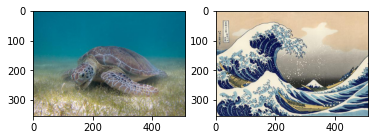

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(img_style)
plt.show()

def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

In [ ]:
x_img = preprocess_input(np.expand_dims(img, axis=0))
x_img_style = preprocess_input(np.expand_dims(img_style, axis=0))

x_img_style.shape

(1, 353, 512, 3)

In [ ]:
def deprocess_img(processed_img: np.array):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ('someething somthing bla bla bla')
  
  if len(x.shape) != 3:
    raise ValueError('Invalid input to deprocessing image')
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x


In [ ]:
# content layers:
content_layers = ['block5_conv2']

#style layers we are interested in:
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

In [ ]:
style_outputs = [vgg.get_layer(name).output for name in style_layers]
content_outputs = [vgg.get_layer(name).output for name in content_layers]
model_outputs = style_outputs + content_outputs

model = keras.models.Model(vgg.input, model_outputs)


In [ ]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content, target))
  

In [ ]:
def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  gram_style = gram_matrix(base_style)

  return tf.reduce_mean(gram_style - gram_target)

In [ ]:
def get_feature_representation(model):
  # batch compute content and style features
  style_outputs = model(x_img_style)
  content_outputs = model(x_img)

  # get the style and content features representations from the model
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features


def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weights, content_weights = loss_weights

  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_ouput_features = model_outputs[num_style_layers:]

  style_score = 0
  content_score = 0

  # accumulate style losses from all layers 
  # here, we exually weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score +=  weight_per_style_layer * get_style_loss(comb_style[0], target_style)

  # accumulate content losses from one layer
  weights_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_ouput_features):
    content_score = weights_per_content_layer * get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weights 
  content_score *= content_weights 
  
  loss = style_score + content_score 
  return loss, style_score, content_score


In [ ]:
num_iterations = 100
content_weights = 1e3
style_weights = 1e-2

style_features, content_features = get_feature_representation(model)
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

init_image = np.copy(x_img)
init_image = tf.Variable(init_image, dtype=tf.float32)


opt = tf.compat.v1.train.AdamOptimizer(learning_rate=2, beta1=0.99, epsilon=1e-1)
iter_count = 1 
best_loss, best_img = float('inf'), None
loss_weights = (style_weights, content_weights)

cfg = {
    'model': model, 
    'loss_weights': loss_weights, 
    'init_image': init_image, 
    'gram_style_features': gram_style_features,
    'content_features': content_features
}

norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means
imgs = []

for i in range(num_iterations):
  with tf.GradientTape() as tape:
    all_loss = compute_loss(**cfg)
  
  total_loss = all_loss[0]
  grads = tape.gradient(total_loss, init_image)
  
  loss, style_score, content_score = all_loss
  opt.apply_gradients([(grads, init_image)])
  clipped = tf.clip_by_value(init_image, min_vals, max_vals)
  init_image.assign(clipped)

  if loss < best_loss:
    best_loss = loss
    best_img = deprocess_img(init_image.numpy())

    plot_img = deprocess_img(init_image.numpy())
    imgs.append(plot_img)
    print(f'Iteration: {i}')
  


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

In [ ]:
gram_matrix(style_features[1])


<tf.Tensor: shape=(128, 128), dtype=float32, numpy=
array([[7.88945923e+01, 2.15953102e+01, 6.72677681e-02, ...,
        1.29169174e+02, 1.07966064e+02, 3.01013927e+01],
       [2.15953102e+01, 7.94127969e+04, 3.16042207e+04, ...,
        6.13072344e+04, 4.00763398e+04, 3.25628809e+04],
       [6.72677681e-02, 3.16042207e+04, 1.77175984e+05, ...,
        1.25210445e+05, 1.45472275e+04, 6.84653828e+04],
       ...,
       [1.29169174e+02, 6.13072344e+04, 1.25210445e+05, ...,
        2.50804906e+05, 5.05636992e+04, 8.55501797e+04],
       [1.07966064e+02, 4.00763398e+04, 1.45472275e+04, ...,
        5.05636914e+04, 5.29571992e+04, 1.54535869e+04],
       [3.01013966e+01, 3.25628809e+04, 6.84653828e+04, ...,
        8.55501875e+04, 1.54535869e+04, 1.38248484e+05]], dtype=float32)>

In [ ]:
float('inf')

inf

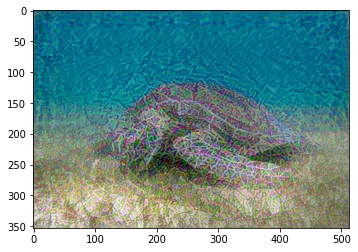

In [ ]:
plt.imshow(best_img)